<a href="https://colab.research.google.com/github/PHMark/ML-Personal-Projects/blob/master/Quora_Duplicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center;font-size:30px;"> Quora Duplicate Questions </h1>

# 1. Business Problem

## 1.1 Description

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>

> Credits: Kaggle 


### Problem Statement

- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

## 1.2 Sources/Other Links


- Source : https://www.kaggle.com/c/quora-question-pairs

**Others:**
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

## 1.3 Real world/Business Objectives and Constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

# 2. Machine Learning Probelm

## 2.1 Data

### 2.1.1 Data Overview

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

## 2.2 Mapping the real world problem into a Machine Learning problem

### 2.2.1 Type of Machine Leaning Problem

<p> This is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

### 2.2.2 Performance Metric 

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss

## 2.3 Train and Test Construction

<p> We will build train and test set randomly, splitting in the ratio of 70:30. </p>

# 3. Exploratory Data Analysis 

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
try:
  from fuzzywuzzy import fuzz
except:
  !pip install fuzzywuzzy
  from fuzzywuzzy import fuzz
try:
  import distance
except:
  !pip install distance
  import distance
import re
import os
import time

QUORA_DATA_DIR = '/content/drive/My Drive/Datasets/quora_kaggle/'

In [0]:
df = pd.read_csv(QUORA_DATA_DIR + 'train.csv')

In [3]:
print('Number of Rows: {}\nNumber of Columns: {}'.format(*df.shape))

Number of Rows: 404290
Number of Columns: 6


In [4]:
# Inspect some data
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

### 3.2.1 Distribution of data points among output classes
- Number of duplicate(smilar) and non-duplicate(non similar) questions

In [0]:
# Some useful function

def put_label(rects, data, axes):
  '''Put bar plot values'''
  for rect, i in zip(rects, data):
        h = rect.get_height()/2
        axes.text(rect.get_x() + rect.get_width()/2., h ,str(i),
                ha='center', color='white', fontsize=10)

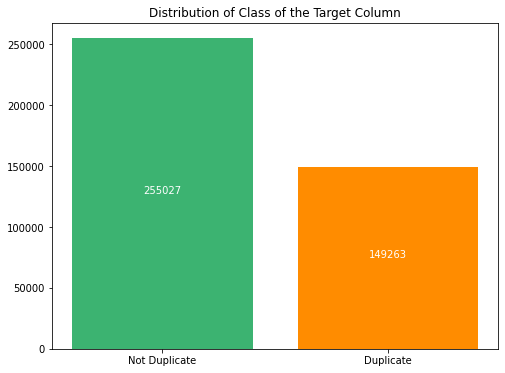

In [7]:
height = df['is_duplicate'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Distribution of Class of the Target Column')
rects = ax.bar(x=df['is_duplicate'].unique(), height=height, 
               color=['mediumseagreen', 'darkorange'])
ax.set_xticks(ticks=[0, 1])
ax.set_xticklabels(labels=['Not Duplicate', 'Duplicate'])
put_label(rects, height, ax)
plt.show()

In [8]:
print('Percentage of questions that are not duplicate (is_duplicate = 0): {}%'.format(round(100*height.iloc[0]/height.sum(), 2)))
print('Percentage of questions that are duplicate (is_duplicate = 1): {}%'.format(round(100*height.iloc[1]/height.sum(), 2)))

Percentage of questions that are not duplicate (is_duplicate = 0): 63.08%
Percentage of questions that are duplicate (is_duplicate = 1): 36.92%


Observation(s): 
* As we can see here, the distribution of class on is_duplicate column is imbalance. Hence, it's a good idea to use *Binary Confusion Matrix* as a secondary performance metric.


### 3.2.2 Number of unique questions

We can consider a unique question as a question that was mentioned or partnered in this dataset only once, and the repeated questions are those that were partnered more than once.

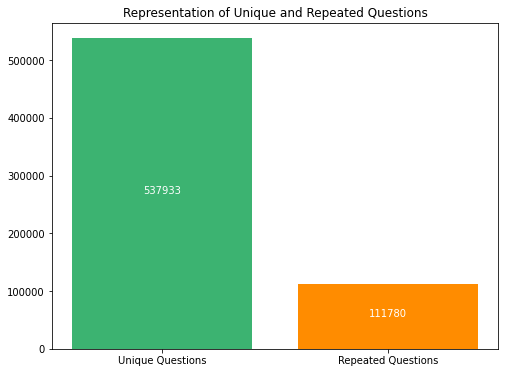

In [9]:
q1_plus_q2 = pd.concat([df['qid1'], df['qid2']])

unique_questions = q1_plus_q2.unique()
question_frequency = q1_plus_q2.value_counts()
questions_occured_more_than_once = question_frequency > 1
repeated_questions = np.sum(questions_occured_more_than_once)
max_repeated_question = question_frequency[questions_occured_more_than_once].max()

height = [len(unique_questions), repeated_questions]
fig, ax = plt.subplots(figsize=(8, 6))
rects = ax.bar(x=['Unique Questions', 'Repeated Questions'], 
               height=height, color=['mediumseagreen', 'darkorange'])
put_label(rects, height, ax)
plt.title('Representation of Unique and Repeated Questions')
plt.show()

In [0]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
# fig.suptitle('Distribution of Mean Class in Repeated Questions')
# sns.distplot(a=df.loc[(df['qid1'].isin(question_frequency[questions_occured_more_than_once].index)) |
#        (df['qid2'].isin(question_frequency[questions_occured_more_than_once].index))].groupby('qid1').mean()['is_duplicate'], 
#              color='blue', label='qid1',ax=ax[0])
# sns.distplot(a=df.loc[(df['qid1'].isin(question_frequency[questions_occured_more_than_once].index)) |
#        (df['qid2'].isin(question_frequency[questions_occured_more_than_once].index))].groupby('qid2').mean()['is_duplicate'], 
#              color='orange', label='qid2', ax=ax[1])
# fig.legend()
# plt.show()

In [0]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
# fig.suptitle('Distribution of Mean Class in Unique Questions')
# sns.distplot(a=df.loc[(df['qid1'].isin(unique_questions)) |
#        (df['qid2'].isin(unique_questions))].groupby('qid1').mean()['is_duplicate'], 
#              color='blue', label='qid1',ax=ax[0])
# sns.distplot(a=df.loc[(df['qid1'].isin(unique_questions)) |
#        (df['qid2'].isin(unique_questions))].groupby('qid2').mean()['is_duplicate'], 
#              color='orange', label='qid2', ax=ax[1])
# fig.legend()
# plt.show()

### 3.2.3 Checking for Duplicate Datapoints

In [12]:
duplicate_df = df.groupby(['qid1', 'qid2']).count() > 1
print('Total number of duplicate datapoints: %d' % np.sum(duplicate_df['id']))

Total number of duplicate datapoints: 0


Observation(s): 
* There are no duplicate pairs of questions in the dataset. However, there are 111,780 repeated questions, this questions might be those of the Frequently Asked Questions in Quora.

### 3.2.4 Number of occurrences of each question

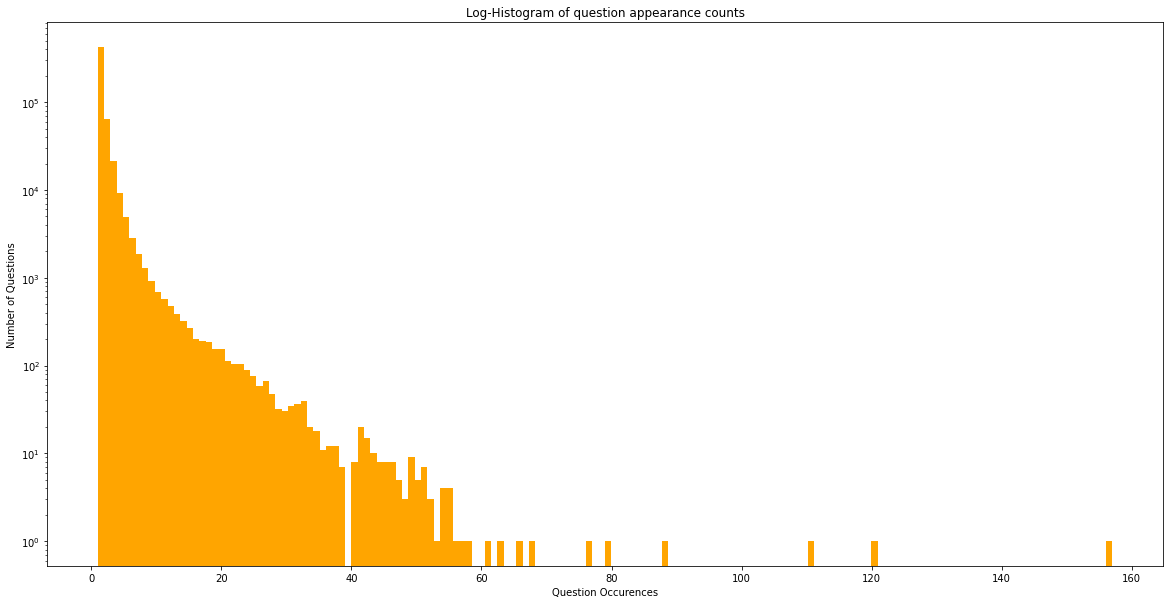

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Log-Histogram of question appearance counts')
ax.hist(x=question_frequency, bins=160, color='orange')
ax.set_yscale('log')
ax.set_xlabel('Question Occurences')
ax.set_ylabel('Number of Questions')
plt.show()

### 3.2.5 Checking for NULL values

In [14]:
rows_with_null = df[df.isnull().any(1)]
rows_with_null

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


There are 2 rows with NaN/Null column value on question2, and 1 row on question1. We can fill those null values with an empty string as this datapoints are not duplicate.

In [15]:
# Fill NaN values with a space
df = df.fillna(' ')
rows_with_null = df[df.isnull().any(1)]
rows_with_null

,id,qid1,qid2,question1,question2,is_duplicate


## 3.3 Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [0]:
# Some helpful functions

def get_total_common_words(row):
  '''Get the intersection between question1 and question2'''
  w1 = set(map(lambda s: s.lower().strip(), row['question1'].split()))
  w2 = set(map(lambda s: s.lower().strip(), row['question2'].split()))
  return 1.0 * len(w1&w2)

def get_total_words(row):
  '''Get the union of question1 and question2'''
  w1 = set(map(lambda s: s.lower().strip(), row['question1'].split()))
  w2 = set(map(lambda s: s.lower().strip(), row['question2'].split()))
  return 1.0 * len(w1)+len(w2)

In [17]:
# IF data is already preprocessed
if os.path.isfile(QUORA_DATA_DIR + 'df_fe_without_preprocessing.csv'):
  df = pd.read_csv(QUORA_DATA_DIR + 'df_fe_without_preprocessing.csv', encoding='latin-1')

else:
  df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
  df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
  df['q1len'] = df['question1'].str.len()
  df['q2len'] = df['question2'].str.len()
  df['q1_n_words'] = df['question1'].apply(lambda s: len(s.split(' ')))
  df['q2_n_words'] = df['question2'].apply(lambda s: len(s.split(' ')))
  df['word_Common'] = df[['question1', 'question2']].apply(get_total_common_words, axis=1)
  df['word_Total'] = df[['question1', 'question2']].apply(get_total_words, axis=1)
  df['word_share'] = df['word_Common']/df['word_Total']
  df['freq_q1+freq_q2'] = df['freq_qid1'] + df['freq_qid2']
  df['freq_q1-freq_q2'] = np.abs(df['freq_qid1'] - df['freq_qid2'])

  # Save as CSV for later use
  df.to_csv(QUORA_DATA_DIR + 'df_fe_without_preprocessing.csv', index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### 3.3.1 Analysis of some of the Extracted Features

In [18]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


#### 3.3.1.2 Feature: word_Common
Let's see how useful the word_Common column on predicting duplicate and non-duplicate questions.

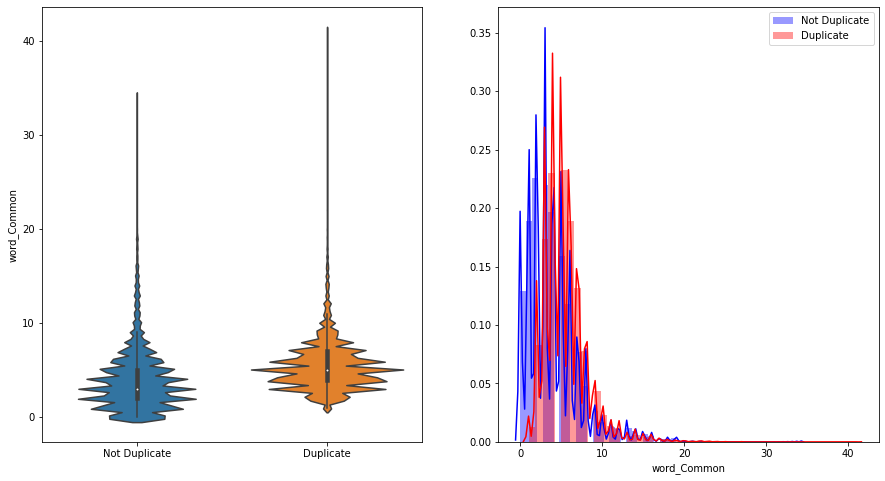

In [19]:
plt.figure(figsize=(15, 8))

# Violin Plot
plt.subplot(121)
sns.violinplot(x='is_duplicate', y='word_Common', data=df)
plt.xticks(ticks=[0, 1], labels=['Not Duplicate', 'Duplicate'])
plt.xlabel('')

# Distribution Plot
plt.subplot(122)
sns.distplot(a=df.loc[df['is_duplicate']==0, 'word_Common'], 
             color='blue', label='Not Duplicate')
sns.distplot(a=df.loc[df['is_duplicate']==1, 'word_Common'], 
             color='red', label='Duplicate')
plt.legend()
plt.show()

Observation(s):
* The distribution of word_Common in duplicate and non-duplicate questions are overlapped

#### 3.3.1.2 Feature: word_share

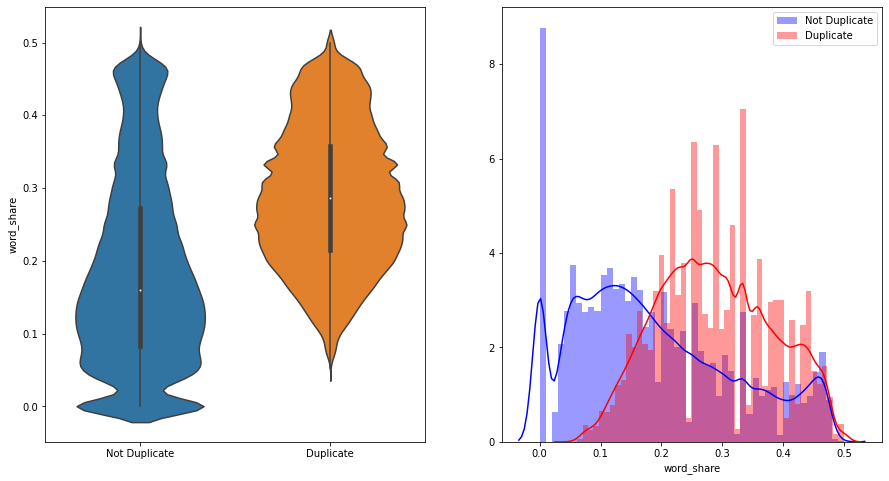

In [20]:
plt.figure(figsize=(15, 8))

# Violin Plot
plt.subplot(121)
sns.violinplot(x='is_duplicate', y='word_share', data=df)
plt.xticks(ticks=[0, 1], labels=['Not Duplicate', 'Duplicate'])
plt.xlabel('')

# Distribution Plot
plt.subplot(122)
sns.distplot(a=df.loc[df['is_duplicate']==0, 'word_share'], 
             color='blue', label='Not Duplicate')
sns.distplot(a=df.loc[df['is_duplicate']==1, 'word_share'], 
             color='red', label='Duplicate')
plt.legend()
plt.show()

Observations: 
* We can see some overlapping area in the distribution plot but we can also see an area where the duplicate and non-duplicate questions are separated. This means that word_share might be a good predictor.
* There is an obvious peak of distribution on the minimum value of word share on the non-duplicate class.
* Duplicate questions seems to have a larger average word share than non-duplicate ones.

## 3.4 Preprocessing of Text
- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [0]:
# Create Text Preprocessing Functions
try:
    STOPWORDS = stopwords.words('english')
except:
  nltk.download('stopwords')
  STOPWORDS = stopwords.words('english')

def to_lower(string):
  return string.lower()

def remove_html_tags(string):
  return re.sub('<.+?>', ' ', string).strip()

def remove_punctuations(string):
  pattern = re.compile('/W')
  return re.sub(pattern, ' ', string)

def stem(string):
  snowball = SnowballStemmer(language='english')
  return snowball.stem(string)

def remove_stop_words(string):
  return ' '.join(s for s in string.split() if s.lower() in STOPWORDS)

def decontract(string):
  string = string.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                                          .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                                          .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                                          .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                                          .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                                          .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                                          .replace("€", " euro ").replace("'ll", " will")
  string = re.sub(r"([0-9]+)000000", r"\1m", string)
  string = re.sub(r"([0-9]+)000", r"\1k", string)
  return string

In [0]:
def preprocess(string, remove_stopwords=False):
  if isinstance(string, str):
    string = to_lower(string)
    string = remove_html_tags(string)
    string = remove_punctuations(string)
    string = stem(string)
    string = decontract(string)

    if remove_stopwords:
      string = remove_stop_words(string)

  return string

## 3.5 Advanced Feature Extraction (NLP and Fuzzy Features)

Some Definition of Terms:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>

- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>

- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>

- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>

- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [0]:
# To get the results in 4 decemal points
EPSILON = 0.0001 

# Create Feature Extraction Functions

def get_token_features(q1, q2):
  '''Extract the first 10 features defined above'''
  token_features = [0.0]*10

  # q1 and q2 tokens
  q1_token = q1.split()
  q2_token = q2.split()

  # If q1 or q2 is an empty string
  if not q1_token or not q2_token:
    return token_features

  # q1 and q2 stop words
  q1_stopwords = set([s for s in q1_token if s in STOPWORDS])
  q2_stopwords = set([s for s in q2_token if s in STOPWORDS])

  # q1 and q2 words
  q1_words = set([s for s in q1_token if s not in STOPWORDS])
  q2_words = set([s for s in q2_token if s not in STOPWORDS])

  # common token in q1 and q2
  common_token = len(set(q1_token).intersection(set(q2_token)))

  # common stop words in q1 and q2
  common_stopwords = len(q1_stopwords.intersection(q2_stopwords))

  # common words in q1 and q2
  common_words = len(q1_words.intersection(q2_words))

  # cwc_min and cwc_max
  token_features[0] = common_words/(min(len(q1_words), len(q2_words)) + EPSILON)
  token_features[1] = common_words/(max(len(q1_words), len(q2_words)) + EPSILON)
  
  # csc_min and csc_max
  token_features[2] = common_stopwords/(min(len(q1_stopwords), len(q2_stopwords)) + EPSILON)
  token_features[3] = common_stopwords/(max(len(q1_stopwords), len(q2_stopwords)) + EPSILON)

  # ctc_min and ctc_max
  token_features[4] = common_token/(min(len(q2_token), len(q2_token)) + EPSILON)
  token_features[5] = common_token/(max(len(q2_token), len(q2_token)) + EPSILON)

  # q1 and q2 last token are equal
  token_features[6] = int(q1_token[-1] == q2_token[-1])

  # q1 and q2 first token are equal
  token_features[7] = int(q1_token[0] == q2_token[0])

  # Abs. length difference of q1 and q2 tokens
  token_features[8] = np.abs(len(q1_token) - len(q2_token))

  # Average Token Length of q1 and q2
  token_features[9] = (len(q1_token) + len(q2_token))/2

  return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [0]:
# Create Feature Extraction Pipeline
def extract_features(_df):
  # Create a DF copy
  _df = _df.copy()

  print('[1/3] Preprocessing Questions....')
  # Preprocess Q1 and Q2
  _df['question1'] = _df['question1'].apply(preprocess)
  _df['question2'] = _df['question2'].apply(preprocess)

  print('[2/3] Extracting the first 10 features....')
  # Get the first 10 advanced features
  token_features = _df.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)

  _df["cwc_min"] = list(map(lambda x: x[0], token_features))
  _df["cwc_max"] = list(map(lambda x: x[1], token_features))
  _df["csc_min"] = list(map(lambda x: x[2], token_features))
  _df["csc_max"] = list(map(lambda x: x[3], token_features))
  _df["ctc_min"] = list(map(lambda x: x[4], token_features))
  _df["ctc_max"] = list(map(lambda x: x[5], token_features))
  _df["last_word_eq"] = list(map(lambda x: x[6], token_features))
  _df["first_word_eq"] = list(map(lambda x: x[7], token_features))
  _df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
  _df["mean_len"] = list(map(lambda x: x[9], token_features))

  print('[3/3] Extracting the FuzzyWuzzy features....')
  # Fuzzywuzzy features
  _df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)
  _df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
  _df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
  _df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
  _df['longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x['question1'], x['question2']), axis=1)

  return _df

In [50]:
if os.path.isfile(QUORA_DATA_DIR + 'nlp_features_train.csv'):
    df = pd.read_csv(QUORA_DATA_DIR + 'nlp_features_train.csv',encoding='latin-1')
else:
    print('Extracting features for train:')
    df = extract_features(df)
    df.to_csv(QUORA_DATA_DIR + 'nlp_features_train.csv', index=False)
df.head(2)

Extracting features for train:
[1/3] Preprocessing Questions....
[2/3] Extracting the first 10 features....
[3/3] Extracting the FuzzyWuzzy features....


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.799984,0.666656,0.999983,0.999983,0.833326,0.833326,0.0,1.0,2.0,13.0,100,93,93,98,0.965517
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.499988,0.222220,0.666644,0.499988,0.307690,0.307690,0.0,1.0,5.0,10.5,86,63,66,73,0.442308


### 3.5.1 Analysis of extracted features

#### 3.5.1.1 Plotting Word clouds

